In [1]:
# Imports

########################################################################
# Python Standard Libraries
import os

########################################################################
# Numpy Library
import numpy as np # linear algebra

########################################################################
# Pandas Library
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

########################################################################
# MATPLOT Library
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator
%matplotlib inline

########################################################################
# SKLearn Library
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_recall_curve, classification_report, confusion_matrix, average_precision_score, roc_curve, auc, multilabel_confusion_matrix

########################################################################
# SCIPY Library
from scipy.stats import gaussian_kde
import scipy.stats as st

In [2]:
def normalize(X, x_min=0, x_max=1):
    nom = (X-X.min(axis=0))*(x_max-x_min)
    denom = X.max(axis=0) - X.min(axis=0)
    denom[denom==0] = 1
    return x_min + nom/denom

class BilinearMap:
    def __init__(self, target_n):
        self.target_cols = target_n

    def compute_coeff(self, X, y):
        try:
            #assert False, 'deliberate'
            Xt = np.transpose(X)
            #print ('X.shape:', X.shape, 'Xt.shape:', Xt.shape)
            Xp = np.dot(Xt, X)
            #print ('Xp.shape:', Xp.shape)
            Xpi = np.linalg.inv(Xp)
            #print ('Xpi.shape:', Xpi.shape)
            XpiXt = np.dot(Xpi, Xt)
            #print ('XpiXt.shape:', XpiXt.shape)
            coeff = np.dot(XpiXt, y)
            print ('coeff.shape:', coeff.shape)
        except Exception as e:
            regressor = LinearRegression(fit_intercept=False)
            regressor.fit(X, y)
            coeff = regressor.coef_
            print ('Exception:', e)

        #coeff = normalize(coeff)
        return coeff

    def fit_transform(self, X, y):
        target_rows = X.shape[1]
        actual_rows = X.shape[0]
        required_rows = target_rows * self.target_cols

        if actual_rows < required_rows:
            assert False, f"{required_rows} rows are required, {actual_rows} are provided"

        Y = []
        for i in range(self.target_cols):
            start = i * target_rows
            end = start + target_rows
            coeff = self.compute_coeff(X[start:end,:], y[start:end])
            Y.extend(coeff.tolist())
            print("coeff.shape:", coeff.shape, "Len y:", len(Y), 'Start:', start, 'End:', end)
        Y = np.array(Y)
        Y = Y.reshape(target_rows, self.target_cols)
        print("Y.shape:", Y.shape)
        Z = np.dot(X, Y)
        return Z

In [3]:
# Utility functions

########################################################################
# Walk through input files
def print_input_files():
    # Input data files are available in the "../input/" directory.
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

########################################################################
# Dump text files
def dump_text_file(fname):
    with open(fname, 'r') as f:
        print(f.read())

########################################################################
# Dump CSV files
def dump_csv_file(fname, count=5):
    # count: 0 - column names only, -1 - all rows, default = 5 rows max
    df = pd.read_csv(fname)
    if count < 0:
        count = df.shape[0]
    return df.head(count)

########################################################################
# Dataset related functions
ds_nbaiot = '/kaggle/input/nbaiot-dataset'
dn_nbaiot = ['Danmini_Doorbell', 'Ecobee_Thermostat', 'Ennio_Doorbell', 'Philips_B120N10_Baby_Monitor', 'Provision_PT_737E_Security_Camera', 'Provision_PT_838_Security_Camera', 'Samsung_SNH_1011_N_Webcam', 'SimpleHome_XCS7_1002_WHT_Security_Camera', 'SimpleHome_XCS7_1003_WHT_Security_Camera']

def fname(ds, f):
    if '.csv' not in f:
        f = f'{f}.csv'
    return os.path.join(ds, f)

def fname_nbaiot(f):
    return fname(ds_nbaiot, f)

def get_nbaiot_device_files():
    nbaiot_all_files = dump_csv_file(fname_nbaiot('data_summary'), -1)
    nbaiot_all_files = nbaiot_all_files.iloc[:,0:1].values
    device_id = 1
    indices = []
    for j in range(len(nbaiot_all_files)):
        if str(device_id) not in str(nbaiot_all_files[j]):
            indices.append(j)
            device_id += 1
    nbaiot_device_files = np.split(nbaiot_all_files, indices)
    return nbaiot_device_files

def get_nbaiot_device_data(device_id, count_norm=-1, count_anom=-1):
    if device_id < 1 or device_id > 9:
        assert False, "Please provide a valid device ID 1-9, both inclusive"
    if count_anom == -1:
        count_anom = count_norm
    device_index = device_id -1
    device_files = get_nbaiot_device_files()
    device_file = device_files[device_index]
    df = pd.DataFrame()
    y = []
    for i in range(len(device_file)):
        fname = str(device_file[i][0])
        df_c = pd.read_csv(fname_nbaiot(fname))
        count = count_anom
        if 'benign' in fname:
            count = count_norm
        rows = count if count >=0 else df_c.shape[0]
        print("processing", fname, "rows =", rows)
        y_np = np.ones(rows) if 'benign' in fname else np.zeros(rows)
        y.extend(y_np.tolist())
        df = pd.concat([df.iloc[:,:].reset_index(drop=True),
                      df_c.iloc[:rows,:].reset_index(drop=True)], axis=0)
    X = df.iloc[:,:].values
    y = np.array(y)
    return (X, y)

def get_nbaiot_devices_data():
    devices_data = []
    for i in range(9):
        device_id = i + 1
        (X, y) = get_nbaiot_device_data(device_id)
        devices_data.append((X, y))
    return devices_data
#print_input_files()

In [4]:
#devices_data = get_nbaiot_devices_data()

In [5]:
def gen_teda_obj(observation, k=None, mean=None, var=None, ecc=None):
    teda = {}
    if not k:
        k = 1
        mean = observation
        var = 0
        ecc = 1
    else:
        if mean is None or var is None or ecc is None:
            assert False, 'mean, variance and ecc values are required'

    teda['k'] = k
    teda['observation'] = observation
    teda['mean'] = mean
    teda['var'] = var
    teda['eccentricity'] = ecc
    teda['typicality'] = 1.0 - ecc
    teda['norm_eccentricity'] = teda['eccentricity'] / 2.0
    teda['norm_typicality'] = teda['typicality'] / (k - 2.0)
    teda['outlier'] = 1.0 if teda['norm_eccentricity'] > (1.0 / k) else 0.0
    teda['normal'] = 1.0 if teda['outlier'] < 0.5 else 0.0
    teda['normal_bool'] = True if teda['normal'] > 0.5 else False
    teda['ecc_threshold'] = 1.0 / k

    return teda


def calc_teda_single(observation, teda = None):
    if not teda:
        teda = gen_teda_obj(observation)
    else:
        k = teda['k'] + 1.0
        mean = teda['mean']
        var = teda['var']

        # Calculate the running mean value
        mean =  (((k - 1)  / k) * mean) + ((1 / k) * observation)

        # Calculate the running mean value
        var = (((k - 1) / k) * var) + (1 / (k - 1)) * np.linalg.norm(observation - mean)

        # Calculate the running eccentricity value
        ecc = (1 / k) +  (np.linalg.norm(mean - observation) / (k * var))

        teda = gen_teda_obj(observation, k, mean, var, ecc)

    return teda

def calc_teda(X):
    teda = None
    teda_output = []
    rows = X.shape[0]
    for i in range(rows):
        teda = calc_teda_single(X[i,:], teda)
        teda_output.append(teda['normal'])

    return teda_output

def predict(X, X_norm, X_anom):
    teda_norm = None
    teda_anom = None
    y_pred = []
    rows = X.shape[0]
    rows_norm = X_norm.shape[0]
    rows_anom = X_anom.shape[0]
    for i in range(rows_norm):
        teda_norm = calc_teda_single(X_norm[i,:], teda_norm)

    for i in range(rows_anom):
        teda_anom = calc_teda_single(X_anom[i,:], teda_anom)

    for i in range(rows):
        teda_norm_tmp = calc_teda_single(X[i,:], teda_norm)
        teda_anom_tmp = calc_teda_single(X[i,:], teda_anom)
        
        if (teda_norm_tmp['normal_bool'] == True):
            y_pred.append(1.0)
            teda_norm = teda_norm_tmp
        else:
            y_pred.append(0.0)
            teda_anom = teda_anom_tmp

        '''
        if (teda_norm_tmp['normal_bool'] == True) and (teda_anom_tmp['normal_bool'] == False):
            y_pred.append(1.0)
            teda_norm = teda_norm_tmp

        elif (teda_norm_tmp['normal_bool'] == False) and (teda_anom_tmp['normal_bool'] == True):
            y_pred.append(0.0)
            teda_anom = teda_anom_tmp

        elif (teda_norm_tmp['normal_bool'] == True) and (teda_anom_tmp['normal_bool'] == True):
            y_pred.append(1.0)
            teda_norm = teda_norm_tmp

        elif (teda_norm_tmp['normal_bool'] == False) and (teda_anom_tmp['normal_bool'] == False):
            y_pred.append(0.0)
            teda_anom = teda_anom_tmp
        '''


    return(np.array(y_pred))

In [6]:
print("=================== TEDA ===================")

=================== TEDA ===================


processing 1.benign.csv rows = 49548
processing 1.gafgyt.combo.csv rows = 59718
processing 1.gafgyt.junk.csv rows = 29068
processing 1.gafgyt.scan.csv rows = 29849
processing 1.gafgyt.tcp.csv rows = 92141
processing 1.gafgyt.udp.csv rows = 105874
processing 1.mirai.ack.csv rows = 102195
processing 1.mirai.scan.csv rows = 107685
processing 1.mirai.syn.csv rows = 122573
processing 1.mirai.udp.csv rows = 237665
processing 1.mirai.udpplain.csv rows = 81982


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


acc,tn,fp,fn,tp
0.49,462395,506355,10595,38953


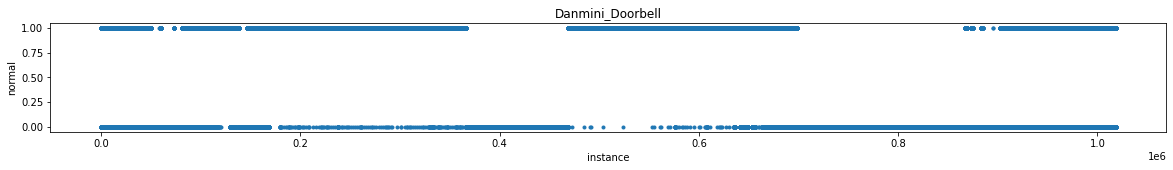

processing 2.benign.csv rows = 13113
processing 2.gafgyt.combo.csv rows = 53012
processing 2.gafgyt.junk.csv rows = 30312
processing 2.gafgyt.scan.csv rows = 27494
processing 2.gafgyt.tcp.csv rows = 95021
processing 2.gafgyt.udp.csv rows = 104791
processing 2.mirai.ack.csv rows = 113285
processing 2.mirai.scan.csv rows = 43192
processing 2.mirai.syn.csv rows = 116807
processing 2.mirai.udp.csv rows = 151481
processing 2.mirai.udpplain.csv rows = 87368


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


acc,tn,fp,fn,tp
0.40,319503,503260,2223,10890


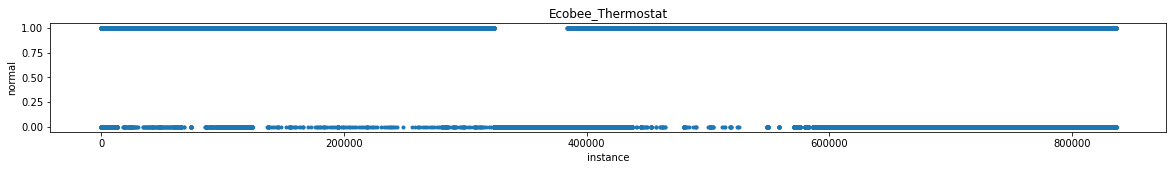

processing 3.benign.csv rows = 39100
processing 3.gafgyt.combo.csv rows = 53014
processing 3.gafgyt.junk.csv rows = 29797
processing 3.gafgyt.scan.csv rows = 28120
processing 3.gafgyt.tcp.csv rows = 101536
processing 3.gafgyt.udp.csv rows = 103933


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


acc,tn,fp,fn,tp
0.15,20802,295598,6189,32911


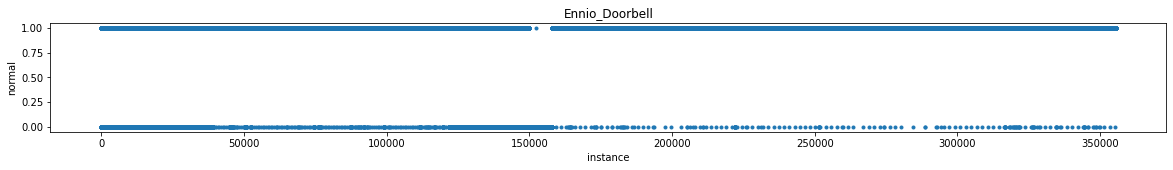

processing 4.benign.csv rows = 175240
processing 4.gafgyt.combo.csv rows = 58152
processing 4.gafgyt.junk.csv rows = 28349
processing 4.gafgyt.scan.csv rows = 27859
processing 4.gafgyt.tcp.csv rows = 92581
processing 4.gafgyt.udp.csv rows = 105782
processing 4.mirai.ack.csv rows = 91123
processing 4.mirai.scan.csv rows = 103621
processing 4.mirai.syn.csv rows = 118128
processing 4.mirai.udp.csv rows = 217034
processing 4.mirai.udpplain.csv rows = 80808


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


acc,tn,fp,fn,tp
0.55,449272,474165,18718,156522


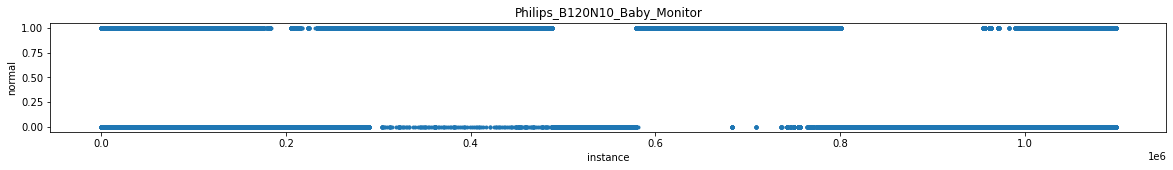

processing 5.benign.csv rows = 62154
processing 5.gafgyt.combo.csv rows = 61380
processing 5.gafgyt.junk.csv rows = 30898
processing 5.gafgyt.scan.csv rows = 29297
processing 5.gafgyt.tcp.csv rows = 104510
processing 5.gafgyt.udp.csv rows = 104011
processing 5.mirai.ack.csv rows = 60554
processing 5.mirai.scan.csv rows = 96781
processing 5.mirai.syn.csv rows = 65746
processing 5.mirai.udp.csv rows = 156248
processing 5.mirai.udpplain.csv rows = 56681


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


acc,tn,fp,fn,tp
0.33,228163,537943,14989,47165


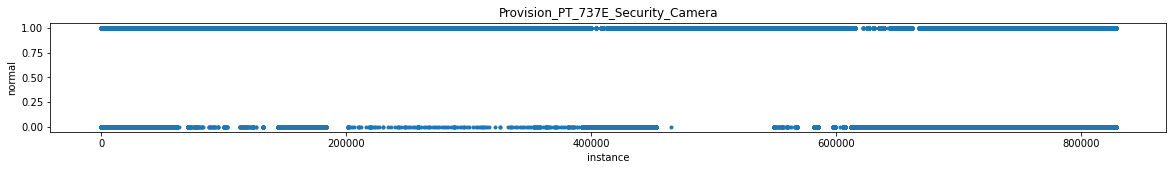

processing 6.benign.csv rows = 98514
processing 6.gafgyt.combo.csv rows = 57530
processing 6.gafgyt.junk.csv rows = 29068
processing 6.gafgyt.scan.csv rows = 28397
processing 6.gafgyt.tcp.csv rows = 89387
processing 6.gafgyt.udp.csv rows = 104658
processing 6.mirai.ack.csv rows = 57997
processing 6.mirai.scan.csv rows = 97096
processing 6.mirai.syn.csv rows = 61851
processing 6.mirai.udp.csv rows = 158608
processing 6.mirai.udpplain.csv rows = 53785


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


acc,tn,fp,fn,tp
0.34,214998,523379,28507,70007


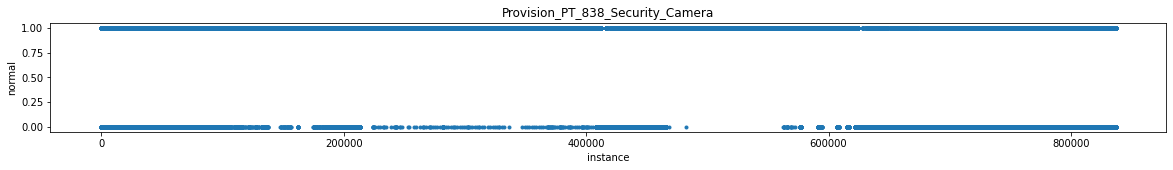

processing 7.benign.csv rows = 52150
processing 7.gafgyt.combo.csv rows = 58669
processing 7.gafgyt.junk.csv rows = 28305
processing 7.gafgyt.scan.csv rows = 27698
processing 7.gafgyt.tcp.csv rows = 97783
processing 7.gafgyt.udp.csv rows = 110617


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


acc,tn,fp,fn,tp
0.18,27185,295887,13311,38839


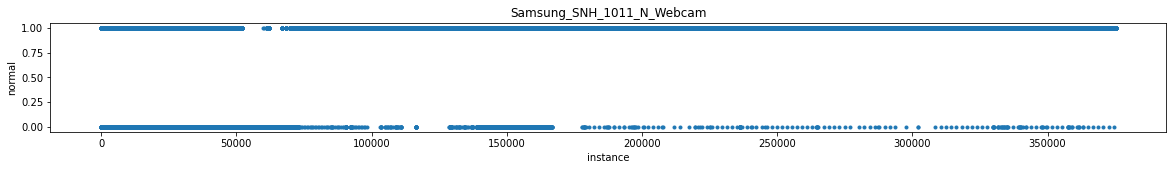

processing 8.benign.csv rows = 46585
processing 8.gafgyt.combo.csv rows = 54283
processing 8.gafgyt.junk.csv rows = 28579
processing 8.gafgyt.scan.csv rows = 27825
processing 8.gafgyt.tcp.csv rows = 88816
processing 8.gafgyt.udp.csv rows = 103720
processing 8.mirai.ack.csv rows = 111480
processing 8.mirai.scan.csv rows = 45930
processing 8.mirai.syn.csv rows = 125715
processing 8.mirai.udp.csv rows = 151879
processing 8.mirai.udpplain.csv rows = 78244


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


acc,tn,fp,fn,tp
0.45,345981,470490,4663,41922


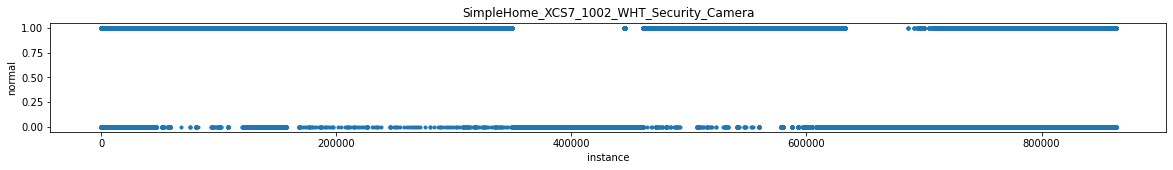

processing 9.benign.csv rows = 19528
processing 9.gafgyt.combo.csv rows = 59398
processing 9.gafgyt.junk.csv rows = 27413
processing 9.gafgyt.scan.csv rows = 28572
processing 9.gafgyt.tcp.csv rows = 98075
processing 9.gafgyt.udp.csv rows = 102980
processing 9.mirai.ack.csv rows = 107187
processing 9.mirai.scan.csv rows = 43674
processing 9.mirai.syn.csv rows = 122479
processing 9.mirai.udp.csv rows = 157084
processing 9.mirai.udpplain.csv rows = 84436


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


acc,tn,fp,fn,tp
0.45,367037,464261,1236,18292


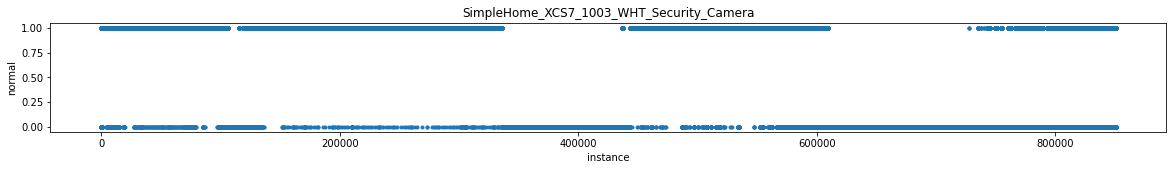

In [7]:
for i in range(9):
    device_index = i
    device_id = device_index + 1
    device_name = dn_nbaiot[device_index]
    (X, y) = get_nbaiot_device_data(device_id)
    X_std = StandardScaler().fit_transform(X)
    y_pred = np.array(calc_teda(X_std))
    tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=[0,1]).ravel()
    acc = accuracy_score(y, y_pred)
    print("acc,tn,fp,fn,tp")
    print(f'{acc:.2f},{tn},{fp},{fn},{tp}')
    plt.figure(figsize=(20,2))
    plt.plot(y_pred, '.')
    plt.title(device_name)
    plt.xlabel('instance')
    plt.ylabel('normal')
    plt.show()

In [8]:
print("=================== Our Work ===================")

=================== Our Work ===================


In [9]:
for i in range(9):
    device_index = i
    device_id = device_index + 1
    device_name = dn_nbaiot[device_index]
    (X, y) = get_nbaiot_device_data(device_id)
    X_std = StandardScaler().fit_transform(X)
    indices_norm = np.where(y >= 0.5)
    indices_anom = np.where(y <= 0.5)
    X_norm_all = X_std[indices_norm]
    X_anom_all = X_std[indices_anom]
    step = 0.05
    cout_frac = 0.0
    print(device_name)
    print("count_norm,count_anom,cout_frac,acc,tn,fp,fn,tp")
    while cout_frac <= 1.01:
        count_norm = int(cout_frac * float(X_norm_all.shape[0]))
        count_anom = int(cout_frac * float(X_anom_all.shape[0]))
        X_norm = X_norm_all[0:count_norm,:]
        X_anom = X_anom_all[0:count_anom,:]
        y_pred = predict(X_std, X_norm, X_anom)
        tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=[0,1]).ravel()
        acc = accuracy_score(y, y_pred)
        print(f'{count_norm:010d},{count_anom:010d},{cout_frac:.2f},{acc:.2f},{tn},{fp},{fn},{tp}')
        cout_frac += step


processing 1.benign.csv rows = 49548
processing 1.gafgyt.combo.csv rows = 59718
processing 1.gafgyt.junk.csv rows = 29068
processing 1.gafgyt.scan.csv rows = 29849
processing 1.gafgyt.tcp.csv rows = 92141
processing 1.gafgyt.udp.csv rows = 105874
processing 1.mirai.ack.csv rows = 102195
processing 1.mirai.scan.csv rows = 107685
processing 1.mirai.syn.csv rows = 122573
processing 1.mirai.udp.csv rows = 237665
processing 1.mirai.udpplain.csv rows = 81982
Danmini_Doorbell
count_norm,count_anom,cout_frac,acc,tn,fp,fn,tp


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


0000000000,0000000000,0.00,0.95,966697,2053,49441,107
0000002477,0000048437,0.05,0.98,968750,0,18460,31088
0000004954,0000096875,0.10,0.98,968750,0,18432,31116
0000007432,0000145312,0.15,0.98,968749,1,18373,31175
0000009909,0000193750,0.20,0.98,968739,11,18221,31327
0000012387,0000242187,0.25,0.98,968734,16,17978,31570
0000014864,0000290625,0.30,0.98,968731,19,17173,32375
0000017341,0000339062,0.35,0.98,968726,24,16945,32603
0000019819,0000387499,0.40,0.98,968723,27,16623,32925
0000022296,0000435937,0.45,0.98,968722,28,16517,33031
0000024773,0000484374,0.50,0.98,968721,29,16474,33074
0000027251,0000532812,0.55,0.98,968721,29,16513,33035
0000029728,0000581250,0.60,0.98,968721,29,16419,33129
0000032206,0000629687,0.65,0.98,968720,30,15823,33725
0000034683,0000678125,0.70,0.98,968717,33,15790,33758
0000037161,0000726562,0.75,0.98,968711,39,15550,33998
0000039638,0000775000,0.80,0.98,968708,42,15479,34069
0000042115,0000823437,0.85,0.98,968706,44,15513,34035
0000044593,0000871875,0.90,0.98

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


0000000000,0000000000,0.00,0.98,821531,1232,13098,15
0000000655,0000041138,0.05,0.79,655040,167723,5333,7780
0000001311,0000082276,0.10,0.79,653342,169421,4915,8198
0000001966,0000123414,0.15,0.79,652536,170227,4719,8394
0000002622,0000164552,0.20,0.79,652106,170657,4551,8562
0000003278,0000205690,0.25,0.79,651745,171018,4462,8651
0000003933,0000246828,0.30,0.79,647973,174790,4350,8763
0000004589,0000287967,0.35,0.71,583994,238769,4157,8956
0000005245,0000329105,0.40,0.70,576880,245883,4133,8980
0000005900,0000370243,0.45,0.53,436705,386058,3973,9140
0000006556,0000411381,0.50,0.52,426486,396277,3691,9422
0000007212,0000452519,0.55,0.52,421061,401702,3642,9471
0000007867,0000493657,0.60,0.51,415876,406887,3559,9554
0000008523,0000534795,0.65,0.50,411901,410862,3508,9605
0000009179,0000575934,0.70,0.49,401883,420880,3423,9690
0000009834,0000617072,0.75,0.49,395960,426803,3353,9760
0000010490,0000658210,0.80,0.48,392121,430642,3259,9854
0000011146,0000699348,0.85,0.48,388589,434174,3159,

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


0000000000,0000000000,0.00,0.31,111138,205262,39086,14
0000001955,0000015820,0.05,0.94,309041,7359,13020,26080
0000003910,0000031640,0.10,0.93,299971,16429,10143,28957
0000005865,0000047460,0.15,0.92,298167,18233,8899,30201
0000007820,0000063280,0.20,0.92,297592,18808,8144,30956
0000009775,0000079100,0.25,0.34,91105,225295,7740,31360
0000011730,0000094920,0.30,0.34,89939,226461,7698,31402
0000013685,0000110740,0.35,0.34,88467,227933,7790,31310
0000015639,0000126559,0.40,0.34,90066,226334,8139,30961
0000017595,0000142380,0.45,0.34,89794,226606,8327,30773
0000019549,0000158199,0.50,0.33,87860,228540,8367,30733
0000021504,0000174019,0.55,0.34,89547,226853,8669,30431
0000023460,0000189840,0.60,0.34,90239,226161,8903,30197
0000025415,0000205660,0.65,0.34,89994,226406,9008,30092
0000027370,0000221480,0.70,0.34,89969,226431,9152,29948
0000029325,0000237300,0.75,0.34,90550,225850,9362,29738
0000031280,0000253120,0.80,0.34,90739,225661,9472,29628
0000033235,0000268940,0.85,0.34,91064,225336,966

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


0000000000,0000000000,0.00,0.84,922600,837,175189,51
0000008762,0000046171,0.05,0.97,923240,197,31110,144130
0000017524,0000092343,0.10,0.72,643594,279843,30860,144380
0000026286,0000138515,0.15,0.72,647645,275792,32751,142489
0000035048,0000184687,0.20,0.97,923240,197,34443,140797
0000043810,0000230859,0.25,0.97,923248,189,35492,139748
0000052572,0000277031,0.30,0.97,923246,191,36044,139196
0000061333,0000323202,0.35,0.71,633203,290234,33146,142094
0000070096,0000369374,0.40,0.70,625276,298161,31789,143451
0000078857,0000415546,0.45,0.70,627491,295946,32915,142325
0000087619,0000461718,0.50,0.70,630217,293220,34154,141086
0000096381,0000507890,0.55,0.70,631940,291497,35040,140200
0000105144,0000554062,0.60,0.70,634420,289017,36096,139144
0000113906,0000600234,0.65,0.70,630707,292730,35562,139678
0000122668,0000646405,0.70,0.70,625548,297889,34650,140590
0000131430,0000692577,0.75,0.69,620741,302696,33646,141594
0000140192,0000738749,0.80,0.69,619158,304279,33461,141779
0000148954,0000

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


0000000000,0000000000,0.00,0.94,766106,0,52348,9806
0000003107,0000038305,0.05,0.97,763014,3092,23675,38479
0000006215,0000076610,0.10,0.70,539535,226571,20353,41801
0000009323,0000114915,0.15,0.66,507487,258619,18854,43300
0000012430,0000153221,0.20,0.64,485283,280823,17865,44289
0000015538,0000191526,0.25,0.62,469174,296932,17266,44888
0000018646,0000229831,0.30,0.60,453960,312146,16793,45361
0000021753,0000268137,0.35,0.59,444667,321439,16584,45570
0000024861,0000306442,0.40,0.57,426134,339972,16383,45771
0000027969,0000344747,0.45,0.56,421684,344422,16206,45948
0000031076,0000383052,0.50,0.56,418347,347759,16058,46096
0000034184,0000421358,0.55,0.56,415321,350785,15978,46176
0000037292,0000459663,0.60,0.55,412223,353883,15914,46240
0000040400,0000497968,0.65,0.55,407441,358665,15851,46303
0000043507,0000536274,0.70,0.54,402619,363487,15829,46325
0000046615,0000574579,0.75,0.53,396387,369719,15808,46346
0000049723,0000612884,0.80,0.52,385349,380757,15778,46376
0000052830,0000651190,

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


0000000000,0000000000,0.00,0.90,738377,0,82552,15962
0000004925,0000036918,0.05,0.95,737038,1339,43964,54550
0000009851,0000073837,0.10,0.67,502713,235664,39392,59122
0000014777,0000110756,0.15,0.64,471726,266651,36839,61675
0000019702,0000147675,0.20,0.62,452385,285992,35244,63270
0000024628,0000184594,0.25,0.60,436844,301533,34271,64243
0000029554,0000221513,0.30,0.59,428687,309690,33658,64856
0000034479,0000258431,0.35,0.58,423261,315116,32995,65519
0000039405,0000295350,0.40,0.58,420184,318193,32551,65963
0000044331,0000332269,0.45,0.58,417330,321047,32170,66344
0000049256,0000369188,0.50,0.58,414621,323756,31769,66745
0000054182,0000406107,0.55,0.57,412600,325777,31466,67048
0000059108,0000443026,0.60,0.57,410293,328084,31175,67339
0000064034,0000479945,0.65,0.56,399424,338953,30895,67619
0000068959,0000516863,0.70,0.55,395978,342399,30733,67781
0000073885,0000553782,0.75,0.55,392673,345704,30559,67955
0000078811,0000590701,0.80,0.55,389993,348384,30479,68035
0000083736,0000627620

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


0000000000,0000000000,0.00,0.31,114879,208193,52146,4
0000002607,0000016153,0.05,0.93,323072,0,26346,25804
0000005215,0000032307,0.10,0.93,323072,0,25926,26224
0000007822,0000048460,0.15,0.93,323072,0,24877,27273
0000010430,0000064614,0.20,0.94,323072,0,23828,28322
0000013037,0000080768,0.25,0.94,323072,0,22650,29500
0000015645,0000096921,0.30,0.94,323072,0,22151,29999
0000018252,0000113075,0.35,0.95,323070,2,19095,33055
0000020860,0000129228,0.40,0.95,323070,2,19372,32778
0000023467,0000145382,0.45,0.95,323070,2,19506,32644
0000026074,0000161535,0.50,0.95,323070,2,19692,32458
0000028682,0000177689,0.55,0.95,323070,2,19859,32291
0000031290,0000193843,0.60,0.95,323070,2,19876,32274
0000033897,0000209996,0.65,0.95,323069,3,18920,33230
0000036505,0000226150,0.70,0.95,323068,4,17265,34885
0000039112,0000242304,0.75,0.95,323068,4,17502,34648
0000041720,0000258457,0.80,0.95,323068,4,17624,34526
0000044327,0000274611,0.85,0.95,323068,4,17771,34379
0000046935,0000290764,0.90,0.95,323068,4,1797

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


0000000000,0000000000,0.00,0.94,814706,1765,46478,107
0000002329,0000040823,0.05,0.70,568195,248276,7206,39379
0000004658,0000081647,0.10,0.70,569273,247198,7887,38698
0000006987,0000122470,0.15,0.70,568787,247684,8098,38487
0000009317,0000163294,0.20,0.70,568772,247699,8411,38174
0000011646,0000204117,0.25,0.70,566716,249755,7711,38874
0000013975,0000244941,0.30,0.70,566534,249937,7770,38815
0000016304,0000285764,0.35,0.70,565690,250781,7106,39479
0000018634,0000326588,0.40,0.70,565585,250886,7115,39470
0000020963,0000367411,0.45,0.70,565626,250845,7301,39284
0000023292,0000408235,0.50,0.70,565683,250788,7458,39127
0000025621,0000449059,0.55,0.70,565791,250680,7671,38914
0000027951,0000489882,0.60,0.70,565883,250588,7882,38703
0000030280,0000530706,0.65,0.70,565273,251198,7329,39256
0000032609,0000571529,0.70,0.70,564973,251498,7242,39343
0000034938,0000612353,0.75,0.70,565064,251407,7412,39173
0000037268,0000653176,0.80,0.70,565079,251392,7555,39030
0000039597,0000694000,0.85,0.70,56

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


0000000000,0000000000,0.00,0.98,831298,0,19469,59
0000000976,0000041564,0.05,0.72,594904,236394,1395,18133
0000001952,0000083129,0.10,0.72,595591,235707,1697,17831
0000002929,0000124694,0.15,0.72,596448,234850,2138,17390
0000003905,0000166259,0.20,0.72,596323,234975,2260,17268
0000004882,0000207824,0.25,0.72,598053,233245,2566,16962
0000005858,0000249389,0.30,0.72,597134,234164,2583,16945
0000006834,0000290954,0.35,0.71,583305,247993,2251,17277
0000007811,0000332519,0.40,0.71,583616,247682,2517,17011
0000008787,0000374084,0.45,0.79,658957,172341,2361,17167
0000009763,0000415648,0.50,0.80,664397,166901,2506,17022
0000010740,0000457213,0.55,0.80,663303,167995,2513,17015
0000011716,0000498778,0.60,0.74,612810,218488,2521,17007
0000012693,0000540343,0.65,0.63,514861,316437,2527,17001
0000013669,0000581908,0.70,0.79,655118,176180,2510,17018
0000014646,0000623473,0.75,0.79,656113,175185,2524,17004
0000015622,0000665038,0.80,0.79,658700,172598,2538,16990
0000016598,0000706603,0.85,0.74,614178